In [32]:
# !pip install numpy scipy matplotlib seaborn scikit-learn mesa==3.0 -q

In [33]:
# Requiero Mesa > 3.0.3
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
from mesa import Agent, Model

# Debido a que puede existir más de un solo agente por celda, haremos uso de ''MultiGrid''.
from mesa.space import MultiGrid

# Con 'BaseScheduler', los agentes se activan de forma secuencial en el orden que fueron agregados.
from mesa.time import BaseScheduler

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# Haremos uso de ''batch_run'' para ejecutar varias simulaciones
from mesa.batchrunner import batch_run

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import contextlib, io
import heapq
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [34]:
class PriorityQueue:
    def __init__(self):
        self.__data = []

    # Función para verificar si la fila de prioridades está vacía
    def empty(self):
        return not self.__data

    # Función para limpiar la fila de prioridades
    def clear(self):
        self.__data.clear()

    # Función para insertar un elemento en la fila de prioridades
    def push(self, priority, value):
        heapq.heappush(self.__data, (priority, value))

    # Función para extraer el elemento con mayor prioridad (menor número)
    def pop(self):
        if self.__data: # not empty
            heapq.heappop(self.__data)
        else:
            raise Exception("No such element")

    # Función para obtener el primer elemento sin sacarlo
    def top(self):
        if self.__data: # not empty
            return self.__data[0]
        else:
            raise Exception("No such element")

In [35]:
class TacoRescueAgent(Agent):
  def __init__(self, model):
    super().__init__(model)
    self.AP = 0
    self.carrying_victim = False
    self.path = []
    self.target = None

  # Método que recarga 4 AP por turno (límite = 8)
  def refill_ap(self):
    self.AP += 4
    if self.AP > 8:
      self.AP = 8

  # Método que verifica si se tienen suficientes AP para una acción
  def can_spend(self, cost):
    return self.AP >= cost

  # Método que resta AP si el agente tiene suficientes
  def spend_AP(self, cost):
    if self.AP >= cost:
      self.AP -= cost
      return True
    return False

  # Método que retorna el estado de una celda:
  # 0: Vacío | 1 = Humo | 2 = Fuego
  def space_state(self, pos):
    x, y = pos
    return int(self.model.fire[x][y])

  # Método que extingue humo de la celda (1AP)
  def remove_smoke(self, pos):
    if self.space_state(pos) != 1:
      return False
    if self.spend_AP(1):
      x, y = pos
      self.model.fire[x][y] = 0
      return True
    return False

  # Método que extingue fuego de la celda (2AP)
  def extinguish_fire(self, pos):
    if self.space_state(pos) != 2:
      return False
    if self.spend_AP(2):
      x, y = pos
      self.model.fire[x][y] = 0
      print(f"uid={getattr(self,'uid',id(self))} at {self.pos} -> extinguish fire")
      return True
    return False

  # Método que convierte fuego en humo en la celda (1AP)
  def fire_to_smoke(self, pos):
    if self.space_state(pos) != 2:
      return False
    if self.spend_AP(1):
      x, y = pos
      self.model.fire[x][y] = 1
      return True
    return False

  # Método que recoge una víctima de la celda
  def pick_up_victim(self, pos):
    if self.carrying_victim:
      return False
    if self.model.poi[pos] != 1:
      return False
    if self.model.poi[pos] == 1 and self.space_state(self.pos) != 2:
      self.carrying_victim = True
      self.model.poi[pos] = 0
      self.model.poi_unknown.remove(pos)
      self.model.unassign_poi(pos)
      self.model.victims_on_board += 1
      return True

    return False

  # Método que deja a la víctima en una entrada segura
  def drop_off_victim(self, pos):
    if not self.carrying_victim:
      return False
    if pos in self.model.entries and self.space_state(self.pos) != 2:
      self.carrying_victim = False
      self.model.rescued_count += 1
      self.model.victims_on_board -= 1
      return True
    return False

  # Método que revisa si hay una puerta entre dos celdas
  def is_door_between(self, pos, target_pos):
    return (pos in self.model.doors and self.model.doors[pos] == target_pos)

  # Método que revisa si una puerta entre dos celdas está cerrada
  def is_door_closed(self, pos, target_pos):
    if not self.is_door_between(pos, target_pos):
      return False
    x1, y1 = pos
    x2, y2 = target_pos
    dx, dy = x2 - x1, y2 - y1
    if dx == 1:
      wall = 1
    elif dx == -1:
      wall = 3
    elif dy == 1:
      wall = 0
    elif dy == -1:
      wall = 2
    else:
      return False
    return self.model.walls[y1][x1][wall] == 1

  # Método que revisa si hay una pared entre dos celdas
  def is_wall_between(self, pos1, pos2):
    x1, y1 = pos1
    x2, y2 = pos2
    dx, dy = x2 - x1, y2 - y1
    if dx == 1:
      wall = 1
    elif dx == -1:
      wall = 3
    elif dy == 1:
      wall = 0
    elif dy == -1:
      wall = 2
    else:
      return False
    return self.model.walls[y1][x1][wall] == 1

  # Método que abre una puerta entre dos celdas
  def open_door(self, target_pos):
    if not self.is_door_between(self.pos, target_pos):
      return
    x1, y1 = self.pos
    x2, y2 = target_pos
    dx, dy = x2 - x1, y2 - y1
    if dx == 1:
      wall = 1
      opp = 3
    elif dx == -1:
      wall = 3
      opp = 1
    elif dy == 1:
      wall = 0
      opp = 2
    elif dy == -1:
      wall = 2
      opp = 0
    else:
      return
    self.model.walls[y1][x1][wall] = 0
    self.model.walls[y2][x2][opp] = 0

  # Método que daña una pared entre dos celdas; si llega a 2 daños, se destruye.
  def damage_wall(self, pos1, pos2):
    if not self.is_wall_between(pos1, pos2):
      return
    x1, y1 = pos1
    x2, y2 = pos2
    dx, dy = x2 - x1, y2 - y1
    if dx == 1:
      wall = 1
      opp = 3
    elif dx == -1:
      wall = 3
      opp = 1
    elif dy == 1:
      wall = 0
      opp = 2
    elif dy == -1:
      wall = 2
      opp = 0
    else:
      return

    # Acumula daño (2 golpes -> se destruye)
    if self.model.walls[y1][x1][wall] == 1:
      self.model.walls_damage[x1][y1][wall] += 1
      self.model.damage += 1
      if self.model.walls_damage[x1][y1][wall] == 2:
        self.model.walls[y1][x1][wall] = 0

    # También daña la pared opuesta en la celda vecina
    if 0 <= x2 < self.model.grid.width and 0 <= y2 < self.model.grid.height:
      if self.model.walls[y2][x2][opp] == 1:
        self.model.walls_damage[x2][y2][opp] += 1
        if self.model.walls_damage[x2][y2][opp] >= 2:
          self.model.walls[y2][x2][opp] = 0

  # Método que calcula el costo en AP de moverse a una celda
  def calculate_cost(self, target_pos):
    spaceState = self.space_state(target_pos)
    if self.carrying_victim:
      if spaceState == 2:
        return None
      return 2
    else:
      if spaceState == 2:
        return 2
      return 1

  # Método que devuelve la posición de la entrada más cercana al agente
  def nearest_entry(self):
    x, y = self.pos
    best = None
    best_dis = None
    for ix, iy in self.model.entries:
      d = abs(ix - x) + abs(iy - y)
      if best is None or d < best_dis:
        best = (ix, iy)
        best_dis = d
    return best

  # Método que revisa si la celda actual es una entrada
  def is_entry(self):
    x, y = self.pos
    for ix, iy in self.model.entries:
      if ix == x and iy == y:
        return True
    return False

  # Método que noquea al agente: pierde a la víctima y es movido a una entrada
  def knock_out(self):
    if self.carrying_victim == True:
      self.carrying_victim = False
      self.model.lost_victims += 1
      self.model.victims_on_board -= 1
    self.model.grid.move_agent(self, self.nearest_entry())
    print(f"knock_out: uid={getattr(self,'uid',id(self))} at {self.pos} -> nearest_entry {self.nearest_entry()}")
    return True

  # Método que intenta mover al agente a una celda adyacente considerando muros, puertas y fuego.
  def try_move(self, target_pos):
    cost = self.calculate_cost(target_pos)
    if cost is None:
      return False

    spaceState = self.space_state(target_pos)
    if spaceState == 2:
      if self.AP < cost + 1:
        return False

    # Si hay puerta cerrada, intenta abrirla gastando 1 AP
    if self.is_door_between(self.pos, target_pos):
      if self.is_door_closed(self.pos, target_pos):
        if not self.can_spend(1):
          return False
        self.open_door(target_pos)
        self.spend_AP(1)
        print(f"uid={getattr(self,'uid',id(self))} at {self.pos} -> opened door to {target_pos}")

    # Si hay pared, intenta dañarla gastando 2 AP
    if self.is_wall_between(self.pos, target_pos):
      while self.is_wall_between(self.pos, target_pos) and self.can_spend(2):
        self.damage_wall(self.pos, target_pos)
        self.spend_AP(2)
        print(f"uid={getattr(self,'uid',id(self))} at {self.pos} -> damaged wall toward {target_pos}")

      # Si después de gastar AP todavía hay pared, no puede moverse
      if self.is_wall_between(self.pos, target_pos):
        return False
      # si logró destruirla, el bucle termina y continúa para intentar moverse

    # Revisar si el agente tiene suficiente AP
    if not self.can_spend(cost):
      return False

    # Mover al agente a la celda objetivo
    self.spend_AP(cost)
    self.model.grid.move_agent(self, target_pos)
    print(f"Agent uid={getattr(self,'uid',id(self))} moved to {self.pos} (target was {target_pos})")
    return True

  # Método que obtiene los vecinos de una celda y calcula el coste de pasar por ellos (para A*).
  def neighbors_for_path(self, pos):
    x, y = pos
    candidates = []
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    for dx, dy in directions:
      nx, ny = x + dx, y + dy
      if not (0 <= nx < self.model.grid.width and 0 <= ny < self.model.grid.height):
        continue

      # Calcular el costo base de moverse hacia la celda vecina
      cost = self.calculate_cost((nx, ny))
      if cost is None:
        continue

      # Calcular el costo extra considerando puertas y paredes
      extra = 0
      if self.is_door_between(pos, (nx, ny)):
        if self.is_door_closed(pos, (nx, ny)):
          extra += 1
      elif self.is_wall_between(pos, (nx, ny)):
        extra += 4

      candidates.append(((nx, ny), float(cost + extra)))
    return candidates

  # Método que define la heurística para A*
  def heuristic(self, a, b):
    return float(abs(a[0] - b[0]) + abs(a[1] - b[1]))

  # Método que implementa el algoritmo A* para calcular una ruta entre dos celdas
  def a_star(self, start, goal):
    if start == goal:
      return []

    pq = PriorityQueue()
    pq.push(0.0, start)
    prev = {start: None}
    dist = {start: 0.0}

    while not pq.empty():
      _, current = pq.top()
      pq.pop()

      if current == goal:
        break

      # Explorar vecinos del nodo actual
      for neighbor, step_cost in self.neighbors_for_path(current):
        new_dist = dist[current] + step_cost
        if neighbor not in dist or new_dist < dist[neighbor]:
          dist[neighbor] = new_dist
          priority = new_dist + self.heuristic(neighbor, goal)
          pq.push(priority, neighbor)
          prev[neighbor] = current

    if goal not in prev:
      return None

    # Reconstrucción de la ruta desde el objetivo hacia el inicio
    path = []
    cur = goal
    while cur != start:
      path.append(cur)
      cur = prev[cur]
    path.reverse()
    return path

  # Método que implementa Dijkstra para calcular el coste mínimo entre dos celdas.
  def shortest_cost(self, start, goal):
    if start == goal:
      return 0

    pq = PriorityQueue()
    pq.push(0, start)
    dist = {start: 0}

    while not pq.empty():
      curr_cost, current = pq.top()
      pq.pop()

      if curr_cost > dist.get(current, 'inf'):
        continue

      # Si llegamos al objetivo, devolvemos el coste mínimo
      if current == goal:
        return curr_cost

      # Explorar vecinos del nodo actual
      for neighbor, step_cost in self.neighbors_for_path(current):
        if step_cost is None:
          continue
        new_dist = curr_cost + float(step_cost)
        if neighbor not in dist or new_dist < dist[neighbor]:
          dist[neighbor] = new_dist
          pq.push(new_dist, neighbor)

    # Si no se encontró un camino al objetivo
    return None

  # Método que selecciona el POI más cercano en coste de AP
  def nearest_poi(self):
    best = None
    best_cost = None

    for px, py in list(self.model.poi_unknown):

      # Calcular coste de movimiento hasta este POI
      move_cost = self.shortest_cost(self.pos, (px, py))
      if move_cost is None:
        continue

      # Guardar el mejor candidato
      if best is None or move_cost <= best_cost:
        best = (px, py)
        best_cost = move_cost

    return best

  # Método que selecciona la casilla de fuego más cercana en coste de AP
  def nearest_fire(self):
    best = None
    best_cost = None

    # Recorrer las celdas del grid y continuar con las que tienen fuego
    for ix in range(self.model.grid.width):
      for iy in range(self.model.grid.height):
        state = int(self.model.fire[ix][iy])
        if state != 2:
          continue

        # Calcular el coste de movimiento hasta esta celda
        move_cost = self.shortest_cost(self.pos, (ix, iy))
        if move_cost is None:
          continue

        # Coste adicional de la acción al llegar: 2 AP para fuego
        action_cost = 2
        total = move_cost + action_cost

        # Guardar el mejor candidato
        if best is None or total < best_cost:
          best = (ix, iy)
          best_cost = total

    return best

  # Método que representa el paso (turn) del agente:
  def step(self):
    # Recarga AP al inicio del turno
    self.refill_ap()

    # Si está sobre una POI y no carga víctima, intentarlo
    if self.model.poi[self.pos] == 1 and not self.carrying_victim:
      self.pick_up_victim(self.pos)

    # Decidir objetivo según el estado y el rol asignado del agente
    # Si está cargando una víctima -> dirigirse a la entrada más cercana
    if self.carrying_victim:
      desired_target = self.nearest_entry()

    else:
      # Dirigirse hacia el POI más cercano, si no hay, dirigirse hacia el fuego más cercano
      desired_target = self.nearest_poi()
      if desired_target is None:
        desired_target = self.nearest_fire()

    # Actualizar el objetivo y calcular ruta desde la posición actual.
    if desired_target is not None:
      self.target = desired_target
      self.path = self.a_star(self.pos, self.target) or []

    print(f"Agent uid={getattr(self,'uid',id(self))} pos={self.pos} AP={self.AP} target={self.target} path_len={len(self.path)}")

    # Avanzar por la ruta mientras haya AP y queden pasos en la ruta.
    while self.AP > 0 and self.path:
      next_pos = self.path[0]
      moved = self.try_move(next_pos)
      if moved:
        print(f"Agent moved to {self.pos}")
        self.path.pop(0)

        state = self.space_state(self.pos)

        # Si hay fuego, extinguir si es posible, si no convertir a humo
        if state == 2:
          if self.can_spend(2):
            self.extinguish_fire(self.pos)
          else:
            self.fire_to_smoke(self.pos)

        # Si hay humo, extinguir si es posible
        elif state == 1:
          if self.can_spend(1):
            self.remove_smoke(self.pos)

        # Si la celda tiene un POI con víctima, intentar recogerla
        if self.model.poi[self.pos] == 1 and not self.carrying_victim:
          self.pick_up_victim(self.pos)

        # Si la celda tiene un POI con falsa alarma, revelarlo
        if self.model.poi[self.pos] == 2:
          self.model.poi[self.pos] = 0
          if self.pos in self.model.poi_unknown:
            self.model.poi_unknown.remove(self.pos)
          self.model.unassign_poi(self.pos)

        # Si llegó a una entrada y carga una víctima, dejarla
        if self.is_entry() and self.carrying_victim:
          self.drop_off_victim(self.pos)

        continue

      # Si el movimiento falló, intentar replantear ruta desde la posición actual
      else:
        self.path = self.a_star(self.pos, self.target) or []
        break

    # Si no hay ruta y no hay objetivo, o el objetivo es la posición actual
    if not self.path and desired_target is None or desired_target == self.pos:
      directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
      for dx, dy in directions:
        if self.AP == 0:
          break
        x, y = self.pos
        pos = (x + dx, y + dy)
        if not (0 <= pos[0] < self.model.grid.width and 0 <= pos[1] < self.model.grid.height):
          continue
        state = self.space_state(pos)
        if state == 2 and self.can_spend(2):
          if self.try_move(pos):
            self.extinguish_fire(pos)
        elif state == 1 and self.can_spend(1):
          if self.try_move(pos):
            self.remove_smoke(pos)

In [36]:
def get_grid(model):
  width, height = model.grid.width, model.grid.height
  # Base: todo blanco
  grid = np.ones((height*10, width*10, 3))

  # Colores
  COLOR_FIRE   = [1, 0, 0]        # Rojo
  COLOR_SMOKE  = [0.5, 0.5, 0.5]  # Gris
  COLOR_VICTIM = [0, 0, 1]        # Azul
  COLOR_FALSE  = [1, 1, 0]        # Amarillo
  COLOR_WALL   = [0, 0, 0]        # Negro
  COLOR_WALL_D = [1, 0.5, 0]      # Naranja
  COLOR_AGENT  = [0, 1, 0]        # Verde

  cell_size = 10  # cada celda se escala a 10x10 píxeles

  for x in range(width):
    for y in range(height):
      # Región de píxeles de esta celda
      x0, x1 = x*cell_size, (x+1)*cell_size
      y0, y1 = y*cell_size, (y+1)*cell_size

      # Color base
      color = [1, 1, 1]

      # Fuego / Humo
      if model.fire[x][y] == 2:
        color = COLOR_FIRE
      elif model.fire[x][y] == 1:
        color = COLOR_SMOKE

      # POIs
      if model.poi[x][y] == 1:      # víctima
        color = COLOR_VICTIM
      elif model.poi[x][y] == 2:    # falsa alarma
        color = COLOR_FALSE

      # Pinta la celda
      grid[y0:y1, x0:x1] = color

      # Paredes de la celda
      walls = model.walls[y][x]
      damage = model.walls_damage[x][y]

      # Arriba
      if walls[0] == 1:
        wall_color = COLOR_WALL if damage[0] == 0 else COLOR_WALL_D
        grid[y1-1:y1, x0:x1] = wall_color
      # Derecha
      if walls[1] == 1:
        wall_color = COLOR_WALL if damage[1] == 0 else COLOR_WALL_D
        grid[y0:y1, x1-1:x1] = wall_color
      # Abajo
      if walls[2] == 1:
        wall_color = COLOR_WALL if damage[2] == 0 else COLOR_WALL_D
        grid[y0:y0+1, x0:x1] = wall_color
      # Izquierda
      if walls[3] == 1:
        wall_color = COLOR_WALL if damage[3] == 0 else COLOR_WALL_D
        grid[y0:y1, x0:x0+1] = wall_color

      # Dibujar agentes (si hay)
      agents_here = [a for a in model.grid.get_cell_list_contents([(x, y)]) if isinstance(a, TacoRescueAgent)]
      n_agents = len(agents_here)

      if n_agents > 0:
          sub_size = cell_size // 2  # subdivisión 2x2
          for i, agent in enumerate(agents_here[:4]):  # max 4 visibles
              row = i // 2
              col = i % 2
              x0s = x0 + col * sub_size
              x1s = x0s + sub_size
              y0s = y0 + row * sub_size
              y1s = y0s + sub_size
              grid[y0s:y1s, x0s:x1s] = COLOR_AGENT

  return grid


In [37]:
class TacoRescueModel(Model):
  def __init__(self, width=8, height=6, players=6):
    super().__init__()

    self.grid = MultiGrid(width, height, torus=False)
    self.schedule = BaseScheduler(self)
    self.datacollector = DataCollector(model_reporters=
        {"Grid":get_grid,
        "Walls": lambda model: np.copy(model.walls),
        "WallsDamage": lambda model: np.copy(model.walls_damage),
        "Steps": lambda model: model.steps})

    self.steps = 0
    self.current_index = 0
    self._agent_counter = 0

    self.assigned_pois = {}

    self.damage = 0
    self.rescued_count = 0
    self.lost_victims = 0
    self.victims_count = 10
    self.false_alarms_count = 5
    self.victims_on_board = 0
    self.victims = [(3,4), (7,1)]
    self.false_alarms = [(0,1)]
    self.poi_unknown = [(3,4), (7,1), (0,1)]
    self.fire_pos = [(1,4),(1,3),(2,4),(2,3),(3,3),(3,2),(4,3),(5,1),(5,0),(6,1)]
    self.entries = [(5,5),(0,3),(7,2),(2,0)]
    self.doors_pos = [(1,3,2,3),(2,5,3,5),(3,2,3,1),(4,4,5,4),(4,0,5,0),(5,2,6,2),(6,0,7,0),(7,4,7,3)]

    # Diccionario que almacena información de las puertas
    # Cada puerta conecta dos celdas, se registran en ambos sentidos
    self.doors = {}
    for (x1, y1, x2, y2) in self.doors_pos:
        self.doors[(x1, y1)] = (x2, y2)
        self.doors[(x2, y2)] = (x1, y1)

    # Cada celda tiene un array de 4 paredes: [arriba, derecha, abajo, izquierda]
    # 0: No hay pared / puerta abierta | 1: Si hay pared / puerta cerrada
    self.walls = np.array([
      [[0,0,1,1],[0,0,1,0],[0,0,0,0],[0,0,1,0],[0,1,1,0],[0,0,1,1],[0,1,1,0],[0,1,1,1]],
      [[1,0,0,1],[1,0,0,0],[1,0,0,0],[1,0,0,0],[1,1,0,0],[1,0,0,1],[1,1,0,0],[1,1,0,1]],
      [[0,0,1,1],[0,1,1,0],[0,0,1,1],[0,0,1,0],[0,0,1,0],[0,1,1,0],[0,0,1,1],[0,0,1,0]],
      [[0,0,0,0],[0,1,0,0],[1,0,0,1],[1,0,0,0],[1,0,0,0],[1,1,0,0],[1,0,0,1],[1,1,0,0]],
      [[0,0,0,1],[0,0,0,0],[0,1,1,0],[0,0,1,1],[0,1,1,0],[0,0,1,1],[0,0,1,0],[0,1,1,0]],
      [[1,0,0,1],[1,0,0,0],[1,1,0,0],[1,0,0,1],[1,1,0,0],[0,0,0,1],[1,0,0,0],[1,1,0,0]]])

    # Matriz que almacena daño acumulado en paredes
    self.walls_damage = np.zeros( (width, height, 4) )

    # Matriz que almacena el estado del fuego
    # 0: Vacío | 1 = Humo | 2 = Fuego
    self.fire = np.zeros( (width, height) )
    for (x, y) in self.fire_pos:
      self.fire[x][y] = 2

    # Matriz que almacena el estado de los POI
    # 0: Vacío | 1 = Víctima | 2 = Falsa Alarma
    self.poi = np.zeros( (width, height) )
    for (x, y) in self.victims:
      self.poi[x][y] = 1
      self.victims_count -= 1
    for (x, y) in self.false_alarms:
      self.poi[x][y] = 2
      self.false_alarms_count -= 1

    # Colocar agentes en las entradas del tablero
    i = 0
    while (i < players):

      # Agente 1
      if (i == 0):
        position = self.entries[3]

      # Agente 2
      if (i == 1):
        position = self.entries[0]

      # Agente 3
      if (i == 2):
        position = self.entries[2]

      # Agente 4
      elif (i == 3):
        position = self.entries[2]

      # Agente 5
      elif (i == 4):
        position = self.entries[0]

      # Agente 6
      elif (i == 5):
        position = self.entries[1]

      agent = TacoRescueAgent(self)
      self._agent_counter += 1
      agent.uid = self._agent_counter
      self.grid.place_agent(agent, position)
      self.schedule.add(agent)
      i += 1

  # Método que retorna un agente por uid
  def get_agent_by_uid(self, uid):
    for a in self.schedule.agents:
      if getattr(a, "uid", None) == uid:
        return a
    return None

  # Método que avanza el fuego según las reglas del juego
  def advance_fire(self):
    x = self.random.randrange(self.grid.width)
    y = self.random.randrange(self.grid.height)
    current = self.fire[x][y]

    # Si está vacío -> poner humo
    if current == 0:
      self.fire[x][y] = 1
      if self.is_adjacent_to_fire(x, y):
          self.place_fire(x, y)

    # Si hay humo -> convertir en fuego
    elif current == 1:
        self.place_fire(x, y)

    # Si hay fuego -> explosión
    elif current == 2:
        self.explosion(x, y)

    # Aplicar flashover después de cada avance
    self.flashover()

  # Método que verifica si una celda es adyacente a fuego
  def is_adjacent_to_fire(self, x, y):
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if self.can_propagate(x, y, nx, ny):
            if self.fire[nx][ny] == 2:
                return True
    return False

  # Método que verifica si se puede propagar fuego entre dos celdas
  def can_propagate(self, x, y, nx, ny):
    if not (0 <= nx < self.grid.width and 0 <= ny < self.grid.height):
      return False

    dx, dy = nx - x, ny - y

    # Arriba
    if dx == 0 and dy == 1:
      if self.walls[y][x][0] == 1:
        return False

    # Abajo
    if dx == 0 and dy == -1:
      if self.walls[y][x][2] == 1:
        return False

    # Derecha
    if dx == 1 and dy == 0:
      if self.walls[y][x][1] == 1:
        return False

    # Izquierda
    if dx == -1 and dy == 0:
      if self.walls[y][x][3] == 1:
        return False

    return True

  # Método que maneja una explosión: propaga fuego y daña paredes
  def explosion(self, x, y):
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    for dx, dy in directions:
      nx, ny = x + dx, y + dy
      result = self.damage_wall(x, y, dx, dy)
      if result == "continue" and self.can_propagate(x, y, nx, ny):
        self.shockwave(nx, ny, dx, dy)

  # Método que propaga la onda expansiva en línea recta
  def shockwave(self, x, y, dx, dy):
    while 0 <= x < self.grid.width and 0 <= y < self.grid.height:
      prev_x, prev_y = x - dx, y - dy
      if not self.can_propagate(prev_x, prev_y, x, y):
        break

      # Si encuentra vacío o humo, lo convierte en fuego y se detiene
      if self.fire[x][y] == 0 or self.fire[x][y] == 1:
          self.place_fire(x, y)
          break

      # Si hay fuego, continua la onda expansiva
      elif self.fire[x][y] == 2:
          result = self.damage_wall(x, y, dx, dy)
          if result == "stop":
                break
          x += dx
          y += dy

  # Método que aplica el flashover: humo adyacente a fuego -> fuego
  def flashover(self):
    for y in range(self.grid.height):
      for x in range(self.grid.width):
        if self.fire[x][y] == 1 and self.is_adjacent_to_fire(x, y):
          self.place_fire(x, y)

  # Método que coloca fuego en la posición (x, y)
  def place_fire(self, x, y):
    if not (0 <= x < self.grid.width and 0 <= y < self.grid.height):
      return

    self.fire[x][y] = 2

    if (x, y) in self.poi_unknown:
      self.poi_unknown.remove((x, y))
      self.unassign_poi((x, y))

      if self.poi[x][y] == 1:
        self.lost_victims += 1
      elif self.poi[x][y] == 2:
        self.false_alarms_count -= 1

      self.poi[x][y] = 0

    cell_agents = self.grid.get_cell_list_contents((x, y))
    for agent in cell_agents:
      if isinstance(agent, TacoRescueAgent):
        agent.knock_out()

  # Método que daña paredes y puertas entre dos celdas
  def damage_wall(self, x, y, dx, dy):

    # Arriba
    if dx == 0 and dy == 1:
      wall = 0
      opp_wall = 2
      nx, ny = x, y + 1

    # Abajo
    elif dx == 0 and dy == -1:
      wall = 2
      opp_wall = 0
      nx, ny = x, y - 1

    # Derecha
    elif dx == 1 and dy == 0:
      wall = 1
      opp_wall = 3
      nx, ny = x + 1, y

    # Izquierda
    elif dx == -1 and dy == 0:
      wall = 3
      opp_wall = 1
      nx, ny = x - 1, y

    # Si es una puerta: romper inmediatamente
    if (x, y) in self.doors and self.doors[(x, y)] == (nx, ny):
        # Si estaba abierta, se destruye y la onda PUEDE seguir
        if self.walls[y][x][wall] == 0:
            self.walls[y][x][wall] = 0
            self.walls[ny][nx][opp_wall] = 0
            del self.doors[(x, y)]
            del self.doors[(nx, ny)]
            return "continue"

        # Si estaba cerrada, se destruye y se detiene
        if self.walls[y][x][wall] == 1:
            self.walls[y][x][wall] = 0
            self.walls[ny][nx][opp_wall] = 0
            del self.doors[(x, y)]
            del self.doors[(nx, ny)]
            return "stop"

    # Si es una pared: acumula daño (2 golpes -> se destruye)
    if self.walls[y][x][wall] == 1:
      self.walls_damage[x][y][wall] += 1
      self.damage += 1
      if self.walls_damage[x][y][wall] == 2:
        self.walls[y][x][wall] = 0

      # También daña la pared opuesta en la celda vecina
      if 0 <= nx < self.grid.width and 0 <= ny < self.grid.height:
        if self.walls[ny][nx][opp_wall] == 1:
          self.walls_damage[nx][ny][opp_wall] += 1
          if self.walls_damage[nx][ny][opp_wall] >= 2:
            self.walls[ny][nx][opp_wall] = 0
      return "stop"

    return "continue"

  # Método que asigna un POI en pos (x,y) al agente uid
  def assign_poi(self, pos, uid):
    self.assigned_pois[pos] = uid

  # Método que quita cualquier asignación existente de POI para pos
  def unassign_poi(self, pos):
    if pos in self.assigned_pois:
      del self.assigned_pois[pos]

  # Método que devuelve el uid del agente al que está asignado un POI
  def get_assigned_agent_uid(self, pos):
    return self.assigned_pois.get(pos, None)

  # Método que se encarga de agregar POIs al tablero cuando es necesario
  def replenish_poi(self):
    # Si hay menos de 3 POIs
    while (len(self.poi_unknown) + self.victims_on_board) < 3:
      if self.victims_count <= 0 and self.false_alarms_count <= 0:
        return

      x = self.random.randrange(self.grid.width)
      y = self.random.randrange(self.grid.height)

      # Repetir si hay ya un POI en la posición
      if (x, y) in self.poi_unknown:
        continue

      # Quitar humo/fuego previo a colocar el POI
      if self.fire[x][y] in (1, 2):
        self.fire[x][y] = 0

      self.place_poi(x, y)

  # Método que coloca un POI en el tablero
  def place_poi(self, x, y):
    poi_type = self.poi_type()
    if poi_type is None:
      return

    self.poi[x][y] = poi_type
    self.poi_unknown.append((x, y))

  # Método que devuelve 1 (víctima) o 2 (falsa alarma) según lo que queda en la 'bolsa'.
  def poi_type(self):
    v = self.victims_count
    f = self.false_alarms_count

    if v <= 0 and f <= 0:
      return None

    if v <= 0:
      return 2

    if f <= 0:
      return 1

    total = v + f
    if self.random.random() < (v / total):
      self.victims_count -= 1
      return 1
    else:
      self.false_alarms_count -= 1
      return 2

  # Método que define las condiciones bajo las que finaliza el juego
  def end_game(self):
    if self.rescued_count >= 7:
      print(f"Victoria. Rescued Victims: {self.rescued_count}")
      return True

    if self.damage >= 24:
      print(f"Edificio colapsado. Damage: {self.damage}")
      return True

    if self.lost_victims >= 4:
      print(f"Derrota. Lost Victims: {self.lost_victims}")
      return True

    return False

  # Método que ejecuta un paso del modelo
  def step(self):
    print(f"--- Paso {self.steps} ---")

    self.datacollector.collect(self)

    agent = self.schedule.agents[self.current_index]
    agent.step()
    self.current_index = (self.current_index + 1) % len(self.schedule.agents)


    self.advance_fire()
    self.replenish_poi()

In [38]:
model = TacoRescueModel()

while not model.end_game():
    model.step()

--- Paso 1 ---
Agent uid=1 pos=(2, 0) AP=4 target=(0, 1) path_len=3
Agent uid=1 moved to (1, 0) (target was (1, 0))
Agent moved to (1, 0)
Agent uid=1 moved to (0, 0) (target was (0, 0))
Agent moved to (0, 0)
Agent uid=1 moved to (0, 1) (target was (0, 1))
Agent moved to (0, 1)
--- Paso 2 ---
Agent uid=2 pos=(5, 5) AP=4 target=(3, 4) path_len=3
Agent uid=2 moved to (5, 4) (target was (5, 4))
Agent moved to (5, 4)
uid=2 at (5, 4) -> opened door to (4, 4)
Agent uid=2 moved to (4, 4) (target was (4, 4))
Agent moved to (4, 4)
Agent uid=2 moved to (3, 4) (target was (3, 4))
Agent moved to (3, 4)
--- Paso 3 ---
Agent uid=3 pos=(7, 2) AP=4 target=(7, 1) path_len=1
uid=3 at (7, 2) -> damaged wall toward (7, 1)
uid=3 at (7, 2) -> damaged wall toward (7, 1)
--- Paso 4 ---
Agent uid=4 pos=(7, 2) AP=4 target=(7, 1) path_len=1
Agent uid=4 moved to (7, 1) (target was (7, 1))
Agent moved to (7, 1)
--- Paso 5 ---
Agent uid=5 pos=(5, 5) AP=4 target=(6, 1) path_len=9
Agent uid=5 moved to (5, 4) (target w

/tmp/ipython-input-2308857520.py:6: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in a future version. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = BaseScheduler(self)


In [39]:
# Obtenemos la información que almacenó el colector
# Este nos entregará un DataFrame de pandas que contiene toda la información
all_grids = model.datacollector.get_model_vars_dataframe()
all_walls = model.datacollector.get_model_vars_dataframe()["Walls"]
all_walls_damage = model.datacollector.get_model_vars_dataframe()["WallsDamage"]

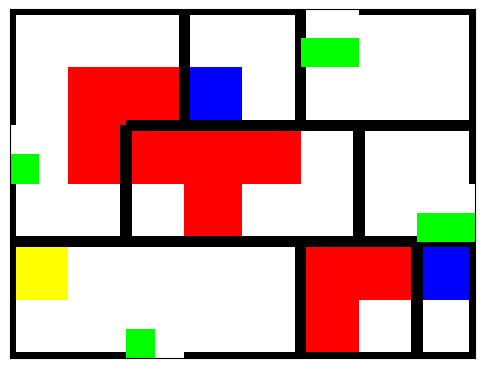

In [40]:
fig, axs = plt.subplots(figsize=(6,6))
axs.set_xticks([])
axs.set_yticks([])

# Primer frame
patch = axs.imshow(all_grids.iloc[0, 0], origin="lower")

def animate(i):
  patch.set_data(all_grids.iloc[i, 0])
  return [patch]

anim = animation.FuncAnimation(fig, animate, frames=len(all_grids), interval=200, blit=True)
plt.show()

In [41]:
anim

In [42]:
def run_single(seed=None, max_steps=100, silent=True):
    model = TacoRescueModel()
    steps = 0

    if silent:
        f = io.StringIO()
        with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            while not model.end_game() and steps < max_steps:
                model.step()
                steps += 1
    else:
        while not model.end_game() and steps < max_steps:
            model.step()
            steps += 1

    return {
        "Steps": steps,
        "Daño": model.damage,
        "Víctimas Rescatadas": model.rescued_count,
        "Víctimas Perdidas": model.lost_victims,
        "Victorias": 1 if model.rescued_count >= 7 else 0
    }

# Correr 1000 simulaciones
runs = 1000
results = []
for i in range(runs):
    res = run_single(seed=None, silent=True)
    results.append(res)

df = pd.DataFrame(results)
summary = {
    "Steps": df["Steps"].mean(),
    "Daño": df["Daño"].mean(),
    "Víctimas Rescatadas": df["Víctimas Rescatadas"].mean(),
    "Víctimas Perdidas": df["Víctimas Perdidas"].mean(),
    "Victorias": int(df["Victorias"].sum())
}

# Mostrar resultados
summary, df.head(10)

/tmp/ipython-input-2308857520.py:6: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in a future version. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = BaseScheduler(self)


({'Steps': np.float64(27.3),
  'Daño': np.float64(23.702),
  'Víctimas Rescatadas': np.float64(3.57),
  'Víctimas Perdidas': np.float64(2.035),
  'Victorias': 37},
    Steps  Daño  Víctimas Rescatadas  Víctimas Perdidas  Victorias
 0     25    24                    2                  1          0
 1     23    25                    3                  2          0
 2     37    26                    6                  2          0
 3     34    25                    4                  3          0
 4     27    24                    4                  2          0
 5     32    25                    4                  2          0
 6     28    25                    4                  3          0
 7     32    24                    6                  1          0
 8     21    25                    3                  1          0
 9     36    25                    4                  2          0)

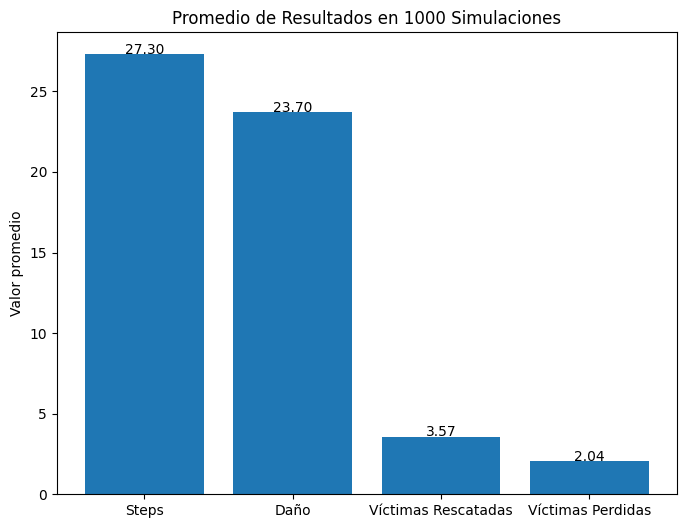

In [43]:
# Gráfico de barras para promedios
metrics = ["Steps", "Daño", "Víctimas Rescatadas", "Víctimas Perdidas"]
values = [summary[m] for m in metrics]

plt.figure(figsize=(8,6))
plt.bar(metrics, values)
plt.title("Promedio de Resultados en 1000 Simulaciones")
plt.ylabel("Valor promedio")
for i, v in enumerate(values):
  plt.text(i, v + 0.05, f"{v:.2f}", ha='center')
plt.show()

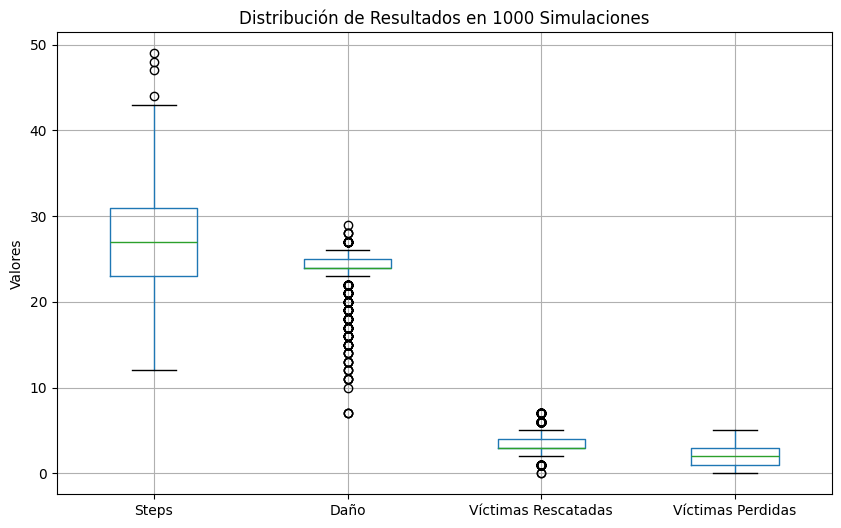

In [44]:
# Boxplots para distribución de resultados
plt.figure(figsize=(10,6))
df[["Steps", "Daño", "Víctimas Rescatadas", "Víctimas Perdidas"]].boxplot()
plt.title("Distribución de Resultados en 1000 Simulaciones")
plt.ylabel("Valores")
plt.show()

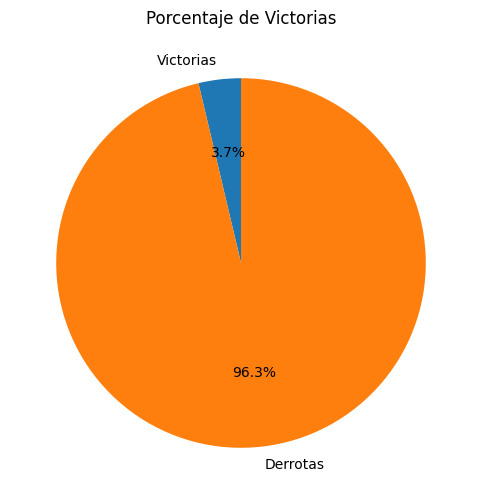

In [45]:
# Gráfico de pastel para victorias/derrotas
wins = summary["Victorias"]
losses = runs - wins

plt.figure(figsize=(6,6))
plt.pie([wins, losses], labels=["Victorias", "Derrotas"], autopct="%1.1f%%", startangle=90)
plt.title("Porcentaje de Victorias")
plt.show()